In [245]:
import torch, shap

import torch
import numpy as np
import xarray as xr
from pathlib import Path

import dask
import json
import geopandas as gpd

from hython.preprocess import apply_normalization
from hython.sampler import RegularIntervalSampler, DataLoaderSpatialSampler
from hython.utils import missing_location_idx, reconstruct_from_missing, load, store_as_zarr, read_from_zarr, reshape_to_2Dspatial
from hython.models.lstm import CustomLSTM

# viz
import matplotlib.pyplot as plt


In [246]:

# choose model from model folder /mnt/CEPH_PROJECTS/InterTwin/Wflow/models
wflow_model =  "talvera_eobs" # alps1km_eobs, adg1km_eobs
EXP = "s001000" # experiment
SEED = 1696

train_start = "2016-01-01"
train_end = "2018-12-31"

test_start = "2019-01-01"
test_end = "2020-12-31"


dynamic_names = ["precip", "pet", "temp"] #  WFLOW forcings, input features of the surrogate
static_names = [ 'thetaS', 'thetaR', 'RootingDepth', 'Swood','KsatVer', "Sl"] # WFLOW static parameters, input features of the surrogate
target_names = [ "vwc"] # WFLOW outputs, targets of the surrogate

# training parameter

SPATIAL_BATCH_SIZE = 256
TEMPORAL_SAMPLING_SIZE = 150 
SEQ_LENGTH = 360 

# model hyper parameters
HIDDEN_SIZE = 24
INPUT_SIZE = len(dynamic_names)
OUTPUT_SIZE = len(target_names)
NUMBER_STATIC_PREDICTORS = len(static_names)


TARGET_INITIALS = "".join([i[0].capitalize() for i in target_names])
train_range = slice(train_start,train_end)
test_range = slice(test_start, test_end)


# paths

wd = Path("/mnt/CEPH_PROJECTS/InterTwin/hydrologic_data/surrogate_training")
input_dir_path = Path('/mnt/CEPH_PROJECTS/InterTwin/Wflow/models') / wflow_model
surrogate_data = wd / f"{wflow_model}.zarr"
surrogate_model = dp_surrogate_model / f"{wflow_model}_{EXP}_v{TARGET_INITIALS}_h{HIDDEN_SIZE}_seed{SEED}.pt"

In [247]:
#load data
Xd = read_from_zarr(url=surrogate_data , group="xd", multi_index="gridcell").sel(time = train_range).xd
Xs = read_from_zarr(url=surrogate_data , group="xs", multi_index="gridcell").xs
Y = read_from_zarr(url=surrogate_data , group="y", multi_index="gridcell").sel(time = train_range).y

Xd_test = read_from_zarr(url=surrogate_data, group="xd", multi_index="gridcell").sel(time = test_range).xd
Y_test = read_from_zarr(url=surrogate_data, group="y", multi_index="gridcell").sel(time = test_range).y

mask_missing = read_from_zarr(url=surrogate_data, group="mask" ).mask
#mask_lake = read_from_zarr(url=surrogate_data, group="mask_lake" ).mask_lake

#wflow_lakes = Xs.sel(feat="wflow_lakeareas").unstack()
wflow_dem = Xs.sel(feat="wflow_dem").unstack()
wflow_landuse = Xs.sel(feat="wflow_landuse").unstack()

# train 
Xd = Xd.sel(feat=dynamic_names)
Xs = Xs.sel(feat=static_names)
Y = Y.sel(feat=target_names)

# test 
Y_test = Y_test.sel(feat=target_names)
Xd_test = Xd_test.sel(feat=dynamic_names)

In [248]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [249]:
# instantiate the sampler, each experiment samples a different number of cells

if EXP == "s001000":    # 1 %
    print("1 %")
    intervals = [4, 4] # km
    val_origin = [2, 2]
    train_origin = [0, 0]
if EXP == "s000100":    # 0.1 %
    print("0.1 %")
    intervals = [11, 11] # km
    val_origin = [6 ,6 ]
    train_origin = [0, 0]
if EXP == "s000010":   # 0.01 %
    print("0.01 %")
    intervals = [34, 34] # km
    val_origin = [18, 18]
    train_origin = [0, 0]
if EXP == "s000001":  # 0.001 %
    print("0.001 %")
    intervals = [108, 108] # km
    val_origin = [64, 64]
    train_origin = [0, 0]
    
spatial_train_sampler = RegularIntervalSampler(intervals = intervals, origin = train_origin)
spatial_val_sampler = RegularIntervalSampler(intervals = intervals, origin = val_origin) 

# Apply the samplers: return the cell indices that can be used later in training and validation to sample the whole spatial domain.
data2d  = wflow_dem.values

sampler_train_meta = spatial_train_sampler.sampling_idx(data2d, mask_missing)
sampler_val_meta = spatial_val_sampler.sampling_idx(data2d, mask_missing)

# some useful metadata
print(sampler_train_meta)

1 %
SamplerResult(
 - id_grid_2d: (82, 127) 
 - idx_sampled_1d: (672,) 
 - idx_sampled_1d_nomissing: (365,)) 
 - idx_missing_1d: (4538,) 
 - sampled_grid_dims: (21, 32) 
 - xr_coords: None


In [250]:
# Normalization
_, d_m, d_std = apply_normalization(Xd[sampler_train_meta.idx_sampled_1d_nomissing], type = "spacetime", how ='standard')
_, s_m, s_std = apply_normalization(Xs[sampler_train_meta.idx_sampled_1d_nomissing], type = "space", how ='standard')
_, y_m, y_std = apply_normalization(Y[sampler_train_meta.idx_sampled_1d_nomissing], type = "spacetime", how ='standard')

d_m,d_std = d_m.compute(), d_std.compute()
s_m, s_std = s_m.compute(), s_std.compute()
y_m, Y_std = y_m.compute() ,y_std.compute()

# use statistics from training to normalize test set (Xs static does not need to be split)
Xs = apply_normalization(Xs, type="space", how="standard",  m1 = s_m, m2 = s_std).compute().values
Xd_test = apply_normalization(Xd_test, type="spacetime", how="standard", m1 = d_m, m2 = d_std).compute().values
Y_test = apply_normalization(Y_test, type="spacetime",how="standard", m1 = y_m, m2 = y_std).compute().values

In [251]:
model = CustomLSTM(INPUT_SIZE, HIDDEN_SIZE, OUTPUT_SIZE, NUMBER_STATIC_PREDICTORS)
model = model.to(device)
model

CustomLSTM(
  (fc0): Linear(in_features=9, out_features=24, bias=True)
  (lstm): LSTM(24, 24, batch_first=True)
  (fc1): Linear(in_features=24, out_features=1, bias=True)
)

In [252]:
model.load_state_dict(torch.load(surrogate_model))

<All keys matched successfully>

In [253]:
Xs = torch.Tensor(Xs).to(device)
Xd_test = torch.Tensor(Xd_test).to(device)

In [254]:
Xd.shape, Xs.shape, device

((10414, 1096, 3), torch.Size([10414, 6]), device(type='cuda', index=0))

In [255]:
model = model.train()
torch.backends.cudnn.enabled=False

In [ ]:
#remove missing values before running shap
idx = missing_location_idx(Xs.cpu().numpy())

Xd_test = Xd_test[~idx]

Xs = Xs[~idx]

In [277]:
Xd_test.shape, Xs.shape

(torch.Size([5876, 731, 3]), torch.Size([5876, 6]))

In [271]:
explainer = shap.GradientExplainer(model, data = [Xd_test[:200,:1], Xs[:200]], batch_size=516)

In [ ]:
import time
start = time.time()
shap_dynamic, shap_static = explainer.shap_values([Xd_test[:,:1], Xs])
end = time.time()
print(end - time.time(),  " (s)")

In [286]:
shap_dynamic.shape, shap_static.shape # gridcell, time, variable, shap value

((5876, 1, 3, 1), (5876, 6, 1))

In [297]:
# viz
shap_s = reconstruct_from_missing(shap_static[:, :, 0], (Xd.shape[0], Xs.shape[1]), idx)
shap_d = reconstruct_from_missing(shap_dynamic[:, 0, : , 0], (Xd.shape[0], Xd.shape[2]), idx)

shap_s.shape, shap_d.shape

(4538, 6)
(4538, 3)


((10414, 6), (10414, 3))

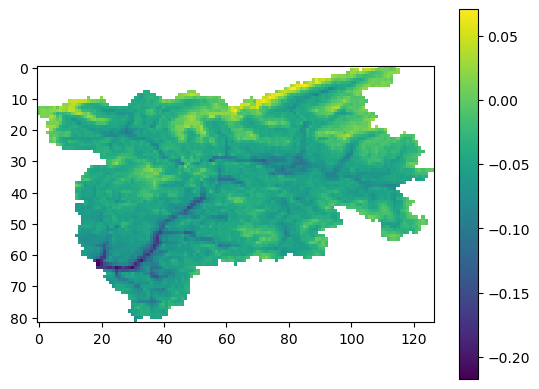

In [300]:
lat, lon = sampler_train_meta.idx_grid_2d.shape
plt.imshow(shap_s.reshape(lat, lon, 6)[..., 0])
plt.colorbar()

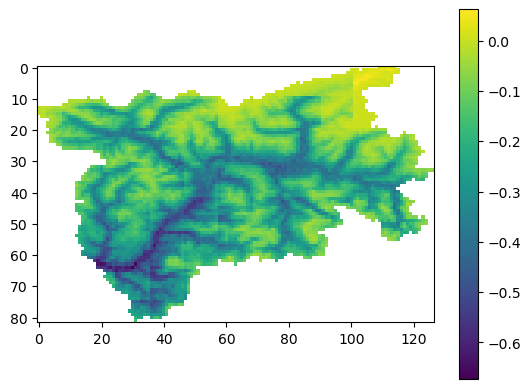

In [303]:
lat, lon = sampler_train_meta.idx_grid_2d.shape
plt.imshow(shap_d.reshape(lat, lon, 3)[..., 0])
plt.colorbar()